# Segmentation of vessels in Magnetic Resonance Angiography

Authors: Paweł Zaręba, Błażej Nowicki, Cyprian Neugebauer

In [1]:
input_path = "./../data_labeled/data/"
processed_input_path = "./../data_labeled/processed_data/"
output_path_wo_prep = "./../data_labeled/generated_labels/"
output_path_with_prep = "./../data_labeled/generated_labels_preprocessed/"
labels_path = "./../data_labeled/labels"
model_path = "./saved_models/manual_0429"

## Predict without preprocessing

In [2]:
from utils import preprocess_procedure, make_prediction

config_wo_prep = {
    "model_name": "unet3d",
    "input_channel": 1,
    "output_channel": 1,
    "filter_number": 16,
    "input_path": input_path,
    "output_path": output_path_wo_prep,
    "thresh": 0.1,
    "connect_thresh": 10,
    "test_model_name": model_path,
    "mip_flag": True
}

make_prediction(**config_wo_prep)

/Users/cyprianneugebauer/Studies/Masters/Semester_2/vessel_segmentation/VesselBoost/.venv/lib/python3.12/site-packages/ants/utils/mni2tal.py:5: SyntaxWarning: invalid escape sequence '\%'
  """
/Users/cyprianneugebauer/Studies/Masters/Semester_2/vessel_segmentation/VesselBoost/.venv/lib/python3.12/site-packages/chart_studio/tools.py:290: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if share_key is "":


Running with CPU


/Users/cyprianneugebauer/Studies/Masters/Semester_2/vessel_segmentation/VesselBoost/utils/module_utils.py:231: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Prediction procedure starts!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:19<00:00, 13.23s/it]


Prediction procedure ends! Please wait for the post processing!
Output processed sub-000_ses-20110101_desc-angio_N4bfc_brain_mask.nii.gz is successfully saved!

Output MIP image sub-000_ses-20110101_desc-angio_N4bfc_brain_mask.nii.gz is successfully saved!

Prediction and thresholding procedure end!



### Sample of predicted segmentation of vessels without preprocessing

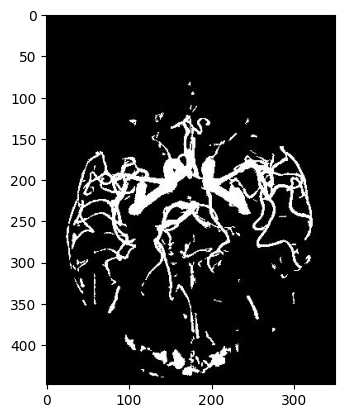

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from pathlib import Path

generated_labels_path = Path(output_path_wo_prep)
generated_labels_files = [f for f in generated_labels_path.iterdir() if f.name.endswith("jpg")]

mip_image = img.imread(generated_labels_files[0])
plt.imshow(mip_image, cmap='gray')

## Predict with preprocessing

If you require preprocessing, there are three options:
 - Set prep_mode to 1 for N4 bias field correction only;
 - Set prep_mode to 2 for denoising only;
 - Set prep_mode to 3 for both. 

In [4]:
config_with_prep = {
    "model_name": "unet3d",
    "input_channel": 1,
    "output_channel": 1,
    "filter_number": 16,
    "input_path": processed_input_path,
    "output_path": output_path_with_prep,
    "thresh": 0.1,
    "connect_thresh": 10,
    "test_model_name": model_path,
    "mip_flag": True
}

preprocess_procedure(ds_path=input_path, ps_path=processed_input_path, prep_mode=1)
make_prediction(**config_with_prep)

The preprocessing procedure is starting!



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.73s/it]


All processed images are successfully saved!
Running with CPU
Prediction procedure starts!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.10s/it]


Prediction procedure ends! Please wait for the post processing!
Output processed sub-000_ses-20110101_desc-angio_N4bfc_brain_mask.nii.gz is successfully saved!

Output MIP image sub-000_ses-20110101_desc-angio_N4bfc_brain_mask.nii.gz is successfully saved!

Prediction and thresholding procedure end!



### Sample of predicted segmentation of vessels with preprocessing

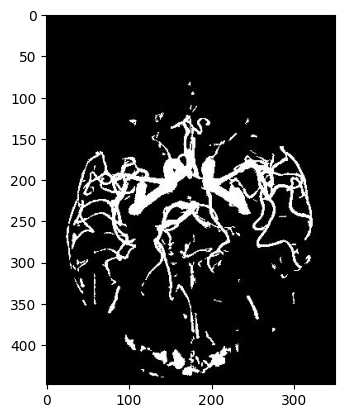

In [5]:
generated_labels_preprocessed_path = Path(output_path_with_prep)
generated_labels_preprocessed_files = [f for f in generated_labels_path.iterdir() if f.name.endswith("jpg")]

mip_image = img.imread(generated_labels_preprocessed_files[0])
plt.imshow(mip_image, cmap='gray')

## Evaluation

In [6]:
from utils import eval_scores
import nibabel as nib

def evaluate(predicted_path, true_path):
    allowed_extensions = {'.nii', '.nii.gz'}
    def filter_files(directory):
        return sorted([
            f for f in directory.iterdir()
            if f.is_file() and f.suffix in allowed_extensions or f.name.endswith('.nii.gz')
        ])
    
    predicted_files = filter_files(Path(predicted_path))
    true_files = filter_files(Path(true_path))
    
    print(f"{'Metric':<24}{'Avg Score':<10}")
    print("-" * 34)
    
    metrics = ["DICE", "Jaccard", "Volume Similarity", "Mutual Information", "Adjusted Rand Index"]
    accum_scores = {metric: 0 for metric in metrics}
    
    for pred_f, true_f in zip(predicted_files, true_files):
        pred_img_data = nib.load(pred_f).get_fdata()
        true_img_data = nib.load(true_f).get_fdata()
        scores = eval_scores(pred_img_data, true_img_data)()
        
        for metric, score in zip(metrics, scores):
            accum_scores[metric] += score

    for metric in metrics:
        accum_scores[metric] /= len(true_files)
        print(f"{metric:<25}{accum_scores[metric]:<10.4f}")
    print("-" * 34)

    return accum_scores

### Evaluation for prediction without preprocessing

In [7]:
eval_scores_wo_prep = evaluate(output_path_wo_prep, labels_path)

Metric                  Avg Score 
----------------------------------
DICE                     0.6904    
Jaccard                  0.5272    
Volume Similarity        0.9342    
Mutual Information       0.5459    
Adjusted Rand Index      0.6880    
----------------------------------


### Evaluation for prediction with preprocessing

In [8]:
eval_scores_with_prep = evaluate(output_path_with_prep, labels_path)

Metric                  Avg Score 
----------------------------------
DICE                     0.6920    
Jaccard                  0.5290    
Volume Similarity        0.9321    
Mutual Information       0.5478    
Adjusted Rand Index      0.6896    
----------------------------------
